In [1]:
import os
import re
import cv2
import shutil

def extract_index(name):
    match = re.search(r"_(\d+)\.mp4$", name)
    return int(match.group(1)) if match else -1

input_root = "/kaggle/input/cricshot10/dataset_256p"
output_root = "/kaggle/working/augmented_dataset_256p"

# Step 1: Copy original dataset to /kaggle/working
if not os.path.exists(output_root):
    shutil.copytree(input_root, output_root)
    print("Original dataset copied to working directory.")

# Step 2: Flip and save with continued numbering
for class_name in os.listdir(output_root):
    class_dir = os.path.join(output_root, class_name)
    if not os.path.isdir(class_dir):
        continue

    video_files = [f for f in os.listdir(class_dir) if f.endswith(".mp4")]
    max_index = max([extract_index(f) for f in video_files])

    next_index = max_index + 1

    for file in video_files:
        video_path = os.path.join(class_dir, file)

        cap = cv2.VideoCapture(video_path)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        new_filename = f"{class_name}_{next_index:04d}.mp4"
        new_path = os.path.join(class_dir, new_filename)

        out = cv2.VideoWriter(new_path, fourcc, fps, (width, height))

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            flipped_frame = cv2.flip(frame, 1)
            out.write(flipped_frame)

        cap.release()
        out.release()

        print(f"Saved flipped: {new_path}")
        next_index += 1


Original dataset copied to working directory.
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0189.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0190.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0191.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0192.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0193.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0194.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0195.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0196.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0197.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0198.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0199.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/cover/cover_0200.mp4
Saved flipped: /kaggle/working/augmented_dataset_256p/

In [2]:
%pip install split-folders
import splitfolders
splitfolders.ratio(input="/kaggle/working/augmented_dataset_256p/", output="/kaggle/working/split_data", seed=1337, ratio=(.70, .15, .15), group_prefix=None, move=False)

Note: you may need to restart the kernel to use updated packages.


Copying files: 3776 files [00:01, 3005.83 files/s]


In [3]:
# Install Hugging Face Transformers and related packages
!pip install -q transformers accelerate einops decord

# Imports
import os
import torch
import random
import numpy as np
import decord
from decord import VideoReader, cpu
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification, VideoMAEConfig
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.7 MB/s eta 0:00:00


2025-08-18 14:53:51.462326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755528831.834629      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755528831.936625      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from glob import glob
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# Class labels
CLASSES = ['cover', 'defense', 'flick', 'hook', 'late_cut', 'lofted', 'pull', 'square_cut', 'straight', 'sweep']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}

# Dataset path
DATASET_ROOT = "/kaggle/working/split_data"

# Frame count (VideoMAE expects 16 for ViT-B base)
NUM_FRAMES = 16
BATCH_SIZE = 8  # Optimal for T4 ×2 setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [6]:
# Load model and set output classes
model_name = "MCG-NJU/videomae-base"
config = VideoMAEConfig.from_pretrained(model_name, num_labels=len(CLASSES))
model = VideoMAEForVideoClassification.from_pretrained(model_name, config=config).to(DEVICE)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Load feature extractor
feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_name)


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/videomae/feature_extraction_videomae.py:28: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from decord import VideoReader, cpu
import numpy as np
import torch

class CricketVideoDataset(Dataset):
    def __init__(self, video_paths, labels, feature_extractor, num_frames=16, mode="train"):
        self.video_paths = video_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.num_frames = num_frames
        self.mode = mode  # 'train', 'val', or 'test'

        if self.mode == "train":
            self.augment = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),  # Preserve full frame info
            transforms.RandomHorizontalFlip(p=0.5),  # Safe
            transforms.ToTensor()
        ])

        else:
            self.augment = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        vr = VideoReader(video_path, ctx=cpu(0))
        total_frames = len(vr)

        mid = total_frames // 2
        half_span = self.num_frames // 2

        # Select indices for 16 frames from center
        if total_frames < self.num_frames:
            indices = np.linspace(0, total_frames - 1, self.num_frames).astype(int)
        else:
            start = max(0, mid - half_span)
            end = min(total_frames, mid + half_span + 1)
            indices = np.linspace(start, end - 1, self.num_frames).astype(int)

        # Decode and augment
        video = vr.get_batch(indices).asnumpy()  # shape: (T, H, W, C)
        augmented_frames = [self.augment(frame) for frame in video]  # [T, C, H, W]

        # Convert to [T, H, W, C] for feature extractor
        frames = [frame.permute(1, 2, 0).numpy() for frame in augmented_frames]

        # Use Hugging Face feature extractor to normalize + convert to [C, T, H, W]
        inputs = self.feature_extractor(frames, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)

        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [8]:
def get_video_paths_and_labels(split_dir):
    video_paths, labels = [], []
    for cls in CLASSES:
        cls_dir = os.path.join(split_dir, cls)
        for file in os.listdir(cls_dir):
            if file.endswith(".mp4"):
                video_paths.append(os.path.join(cls_dir, file))
                labels.append(CLASS_TO_IDX[cls])
    return video_paths, labels

# Train/Val/Test splits
train_videos, train_labels = get_video_paths_and_labels(os.path.join(DATASET_ROOT, "train"))
val_videos, val_labels = get_video_paths_and_labels(os.path.join(DATASET_ROOT, "val"))
test_videos, test_labels = get_video_paths_and_labels(os.path.join(DATASET_ROOT, "test"))

# Datasets
train_dataset = CricketVideoDataset(train_videos, train_labels, feature_extractor, NUM_FRAMES, mode = "train")
val_dataset = CricketVideoDataset(val_videos, val_labels, feature_extractor, NUM_FRAMES, mode="val")
test_dataset = CricketVideoDataset(test_videos, test_labels, feature_extractor, NUM_FRAMES, mode="test")

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [9]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_cosine_schedule_with_warmup

# Training setup
EPOCHS = 50
val_accuracies = []
learning_rate = 3e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.02)
loss_fn = CrossEntropyLoss()

total_steps = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.05 * total_steps), 
    num_training_steps=total_steps
)


In [10]:
def train_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        pixel_values = batch["pixel_values"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # ⚠️ Fix for multi-GPU: ensure scalar loss
        if isinstance(loss, torch.Tensor) and loss.dim() > 0:
            loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)



def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            pixel_values = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc, all_preds, all_labels


In [11]:
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, optimizer, scheduler)
    val_acc, _, _ = evaluate(model, val_loader)

    print(f"Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    val_accuracies.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_videomae_cricket.pth")
        print("✅ Model saved.")



Epoch 1/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3233 | Val Accuracy: 0.0961
✅ Model saved.

Epoch 2/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3202 | Val Accuracy: 0.0961

Epoch 3/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3190 | Val Accuracy: 0.1014
✅ Model saved.

Epoch 4/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3176 | Val Accuracy: 0.1014

Epoch 5/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3097 | Val Accuracy: 0.1032
✅ Model saved.

Epoch 6/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3122 | Val Accuracy: 0.1068
✅ Model saved.

Epoch 7/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3121 | Val Accuracy: 0.1014

Epoch 8/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3128 | Val Accuracy: 0.0996

Epoch 9/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3107 | Val Accuracy: 0.1050

Epoch 10/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3115 | Val Accuracy: 0.1050

Epoch 11/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3104 | Val Accuracy: 0.0961

Epoch 12/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3119 | Val Accuracy: 0.1032

Epoch 13/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3094 | Val Accuracy: 0.0961

Epoch 14/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3084 | Val Accuracy: 0.1032

Epoch 15/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3098 | Val Accuracy: 0.0943

Epoch 16/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3109 | Val Accuracy: 0.1014

Epoch 17/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3091 | Val Accuracy: 0.1014

Epoch 18/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3072 | Val Accuracy: 0.1014

Epoch 19/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3088 | Val Accuracy: 0.1050

Epoch 20/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3069 | Val Accuracy: 0.0961

Epoch 21/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3091 | Val Accuracy: 0.0961

Epoch 22/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3072 | Val Accuracy: 0.1014

Epoch 23/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3079 | Val Accuracy: 0.1014

Epoch 24/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3070 | Val Accuracy: 0.1032

Epoch 25/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3065 | Val Accuracy: 0.1050

Epoch 26/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3068 | Val Accuracy: 0.1014

Epoch 27/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3058 | Val Accuracy: 0.1050

Epoch 28/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3050 | Val Accuracy: 0.0996

Epoch 29/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3057 | Val Accuracy: 0.1014

Epoch 30/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3054 | Val Accuracy: 0.1068

Epoch 31/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3049 | Val Accuracy: 0.1014

Epoch 32/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3055 | Val Accuracy: 0.1050

Epoch 33/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3053 | Val Accuracy: 0.1068

Epoch 34/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3049 | Val Accuracy: 0.1068

Epoch 35/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3041 | Val Accuracy: 0.1050

Epoch 36/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3042 | Val Accuracy: 0.1068

Epoch 37/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3038 | Val Accuracy: 0.1068

Epoch 38/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3033 | Val Accuracy: 0.1014

Epoch 39/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3034 | Val Accuracy: 0.1050

Epoch 40/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3034 | Val Accuracy: 0.1050

Epoch 41/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3029 | Val Accuracy: 0.1050

Epoch 42/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3026 | Val Accuracy: 0.1068

Epoch 43/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3025 | Val Accuracy: 0.1068

Epoch 44/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3023 | Val Accuracy: 0.1068

Epoch 45/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3022 | Val Accuracy: 0.1068

Epoch 46/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3021 | Val Accuracy: 0.1068

Epoch 47/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3020 | Val Accuracy: 0.1068

Epoch 48/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3019 | Val Accuracy: 0.1068

Epoch 49/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3018 | Val Accuracy: 0.1068

Epoch 50/50


Training:   0%|          | 0/330 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Validating:   0%|          | 0

Train Loss: 2.3018 | Val Accuracy: 0.1068


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_test(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):
            pixel_values = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(pixel_values=pixel_values)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return all_preds, all_labels


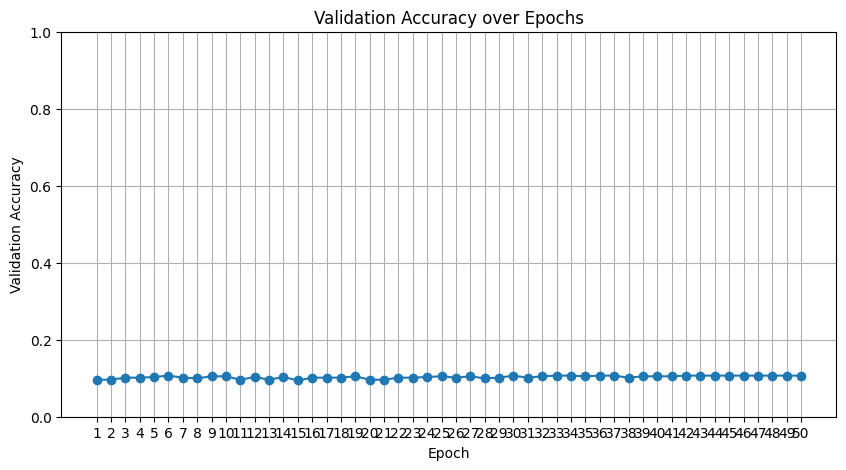

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), val_accuracies, marker='o')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1))
plt.ylim(0, 1)  # Since accuracy is 0.0 to 1.0
plt.show()

Testing:   0%|          | 0/72 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
Testing: 100%|██████████| 72/72 [00:56<00:00,  1.28it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


📊 Classification Report:
              precision    recall  f1-score   support

       cover       0.00      0.00      0.00        57
     defense       0.00      0.00      0.00        59
       flick       0.00      0.00      0.00        55
        hook       0.00      0.00      0.00        55
    late_cut       0.00      0.00      0.00        56
      lofted       0.00      0.00      0.00        60
        pull       0.00      0.00      0.00        55
  square_cut       0.10      1.00      0.19        60
    straight       0.00      0.00      0.00        59
       sweep       0.00      0.00      0.00        59

    accuracy                           0.10       575
   macro avg       0.01      0.10      0.02       575
weighted avg       0.01      0.10      0.02       575



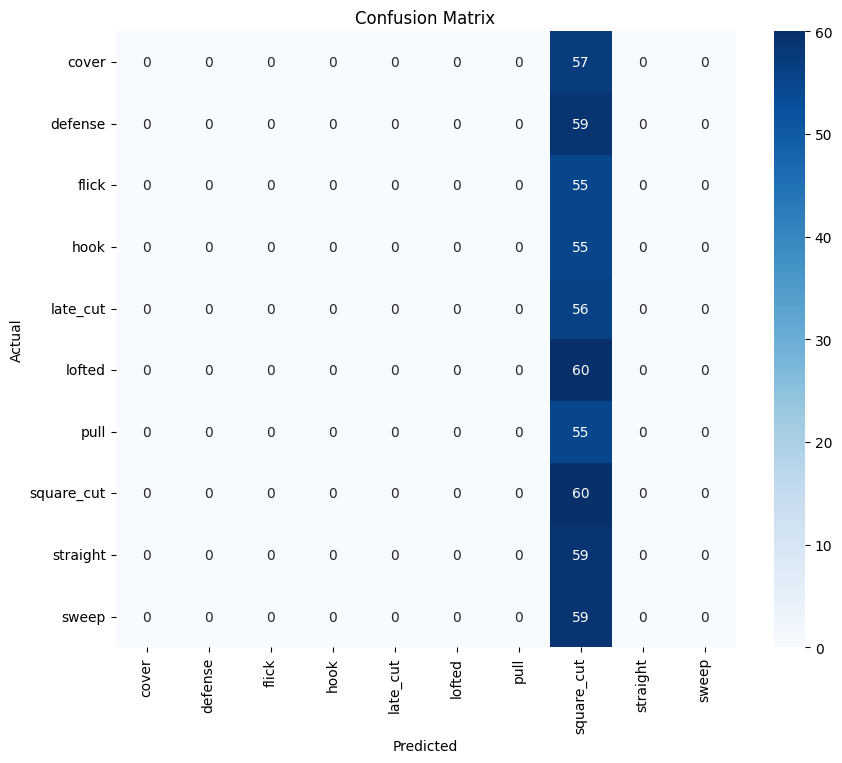

In [14]:
# Evaluate the final or best checkpoint
model.load_state_dict(torch.load("best_videomae_cricket.pth"))  # Use best model
model.eval()

# Run test evaluation
preds, labels = evaluate_test(model, test_loader, CLASSES)
